In [1]:
import numpy as np
import pandas as pd 
import matplotlib as plt
import seaborn as sns
import sklearn as sk 
from pylab import rcParams

#import libraries sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (11, 7)

pd.set_option("display.max_columns", None)

RSEED = 42

In [2]:
# updating path to my environment 
df=pd.read_csv('/Users/julianeberek/neuefische/kickstar/data/final_frame.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168979 entries, 0 to 168978
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             168979 non-null  int64  
 1   blurb                     168977 non-null  object 
 2   converted_pledged_amount  168979 non-null  int64  
 3   country                   168979 non-null  object 
 4   created_at                168979 non-null  object 
 5   deadline                  168979 non-null  object 
 6   disable_communication     168979 non-null  bool   
 7   id                        168979 non-null  int64  
 8   is_starrable              168979 non-null  bool   
 9   launched_at               168979 non-null  object 
 10  name                      168979 non-null  object 
 11  spotlight                 168979 non-null  bool   
 12  staff_pick                168979 non-null  bool   
 13  state                     168979 non-null  o

In [3]:
df = df.state.replace('failed', 0).replace('successful',1)
df

In [ ]:
#log transformation of the goal because it is very skewed 
df['goal_log'] = np.log(df['convert_goal'])

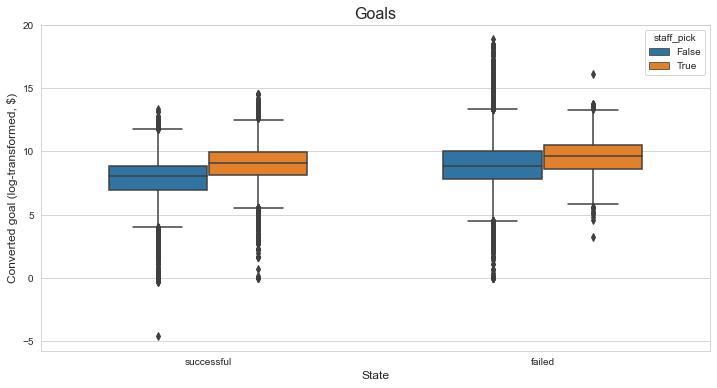

In [70]:
import seaborn as sns

plt.figure(figsize=(12,6))
ax = sns.boxplot(y='goal_log', x='state', data=df, hue='staff_pick', width=.6).set_title('Comparison of goals for project state')
plt.xlabel('State', fontsize=12)
plt.ylabel('Converted goal (log-transformed, $)', fontsize=12) 
plt.title('Goals', fontsize=16)
plt.show()

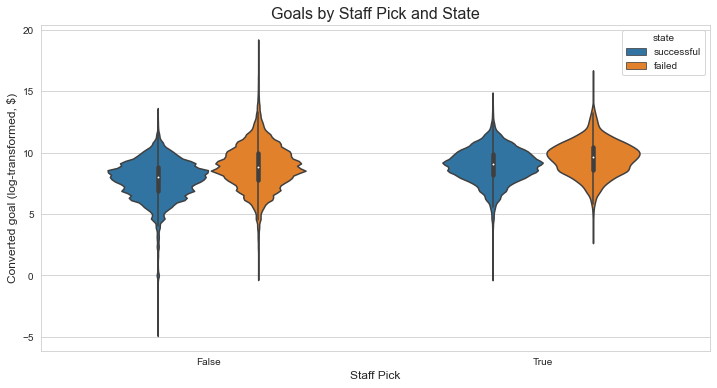

In [77]:
plt.figure(figsize=(12,6))
ax = sns.violinplot(y='goal_log', x='staff_pick', data=df, hue='state', width=.6)
plt.xlabel('Staff Pick', fontsize=12)
plt.ylabel('Converted goal (log-transformed, $)', fontsize=12) 
plt.title('Goals by Staff Pick and State', fontsize=16)
plt.show()

In [37]:
df.category_id.nunique()

15

In [38]:
df_sort = df.groupby('category')['goal_log'].mean().sort_values(ascending=False)
df_sort.index

Index(['technology', 'food', 'film & video', 'games', 'design', 'journalism',
       'fashion', 'theater', 'music', 'photography', 'dance', 'publishing',
       'comics', 'art', 'crafts'],
      dtype='object', name='category')

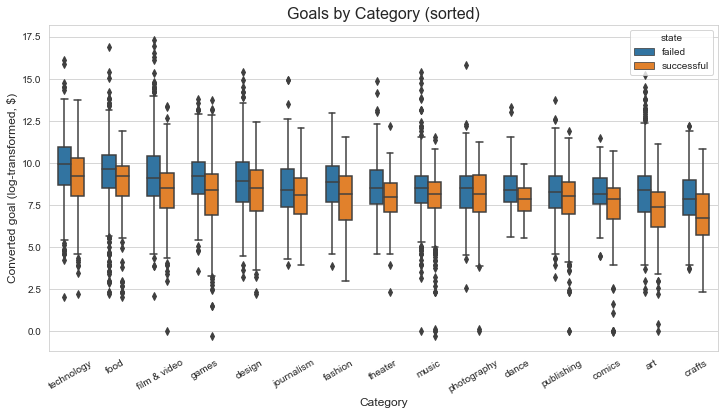

In [75]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(y='goal_log', x='category', data=df.sample(n=16000), hue='state', width=.6, orient='v', order=df_sort.index)
#ax.suptitle('XX')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Converted goal (log-transformed, $)', fontsize=12) 
plt.title('Goals by Category (sorted)', fontsize=16)
plt.show()

In [40]:
features = df.drop(["state"], axis=1)
target = df["state"]

In [41]:
# features_raw= features.drop(["blurb", 'created_at',	'deadline' ,  'id',  'launched_at', 'name','state_changed_at', 'subcategory', 'category', ], axis=1)

# taking out more features: country, is_starrable, disable_communication
features_raw= features.drop(["blurb", 'created_at',	'deadline' ,  'id',  'launched_at', 'name','state_changed_at', 'subcategory', 'category', 'spotlight', 'backers_count', 'is_starrable', 'disable_communication', 'converted_pledged_amount', 'ratio_target'], axis=1)

In [42]:
#features_raw= pd.get_dummies(features_raw, drop_first=True)
features_raw= pd.get_dummies(features_raw, drop_first=True)
features_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168979 entries, 0 to 168978
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   staff_pick     168979 non-null  bool   
 1   subcategy_id   168979 non-null  int64  
 2   category_id    168979 non-null  int64  
 3   month_project  168979 non-null  int64  
 4   weekday        168979 non-null  int64  
 5   duration       168979 non-null  int64  
 6   convert_goal   168979 non-null  float64
 7   goal_log       168979 non-null  float64
 8   country_AU     168979 non-null  uint8  
 9   country_BE     168979 non-null  uint8  
 10  country_CA     168979 non-null  uint8  
 11  country_CH     168979 non-null  uint8  
 12  country_DE     168979 non-null  uint8  
 13  country_DK     168979 non-null  uint8  
 14  country_ES     168979 non-null  uint8  
 15  country_FR     168979 non-null  uint8  
 16  country_GB     168979 non-null  uint8  
 17  country_HK     168979 non-nul

In [43]:
features_raw

,staff_pick,subcategy_id,category_id,month_project,weekday,duration,convert_goal,goal_log,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,False,273,12,8,3,30,1000.0000,6.907755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,False,43,14,5,0,30,15000.0000,9.615805,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,False,273,12,1,3,59,12160.6569,9.405961,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,False,48,18,12,0,30,2800.0000,7.937375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,False,36,14,4,3,30,3500.0000,8.160518,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168974,False,38,14,8,0,58,3883.0000,8.264363,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
168975,False,38,14,5,6,36,5466.5002,8.606394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
168976,False,52,16,8,1,33,2500.0000,7.824046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
168977,False,295,11,3,5,30,5500.0000,8.612503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


0         1
1         1
2         0
3         1
4         1
         ..
168974    1
168975    1
168976    1
168977    1
168978    1
Name: state, Length: 168979, dtype: int64

In [44]:
X_train, X_test, y_train, y_test= train_test_split(features_raw, target, stratify=target, random_state=42, test_size=0.2)
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 135183 samples.
Testing set has 33796 samples.


In [45]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sns.set_style('whitegrid')

<AxesSubplot:xlabel='state', ylabel='count'>

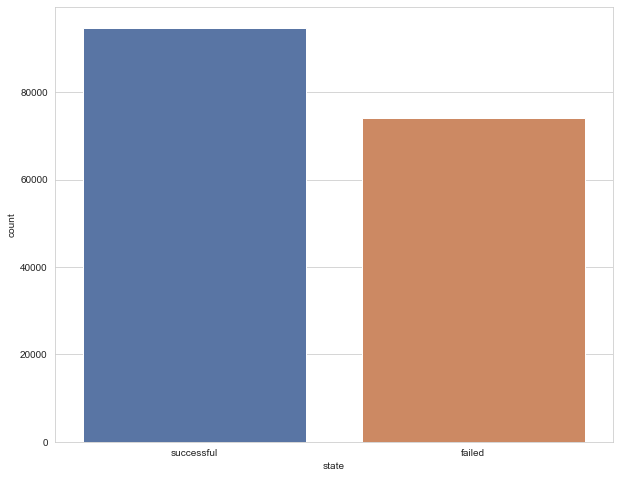

In [46]:
sns.countplot(x="state", data = df, palette='deep')

<AxesSubplot:>

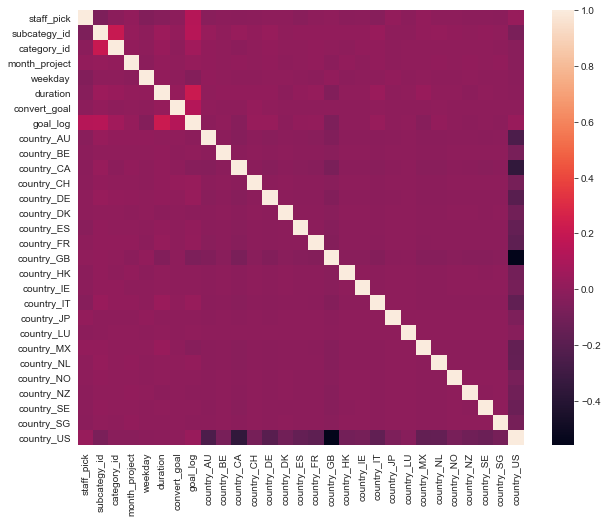

In [47]:
sns.heatmap(features_raw.corr())

In [48]:
# spotlight and subcategory are highly correlated - might be taken out (one of them)
# backers_count and converted_pledged_amount are highly correlated (take out backers count)

Plots

Logistic regression 

In [51]:
#logistic_regression = LogisticRegression(penalty='l1', solver='saga', max_iter=5000) #adapted hyperparameters: penalty + 'saga'
logistic_regression = LogisticRegression(max_iter=1000) #adapted hyperparameters: penalty + 'saga'
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)

In [52]:
from sklearn import metrics
from sklearn.metrics import classification_report
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))


print("Logistic regression score for training set:", round(logistic_regression.score(X_train, y_train),5))
print("Logistic regression score for test set:", round(logistic_regression.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print(logistic_regression.coef_)
# accuracy slightly worse than without setting hyperparameters 

Accuracy:  0.6647532252337555
Logistic regression score for training set: 0.66593
Logistic regression score for test set: 0.66475

Classification report:
              precision    recall  f1-score   support

      failed       0.61      0.68      0.64     14840
  successful       0.72      0.65      0.69     18956

    accuracy                           0.66     33796
   macro avg       0.66      0.67      0.66     33796
weighted avg       0.67      0.66      0.67     33796

[[ 9.42096199e-02 -5.18594201e-03  2.79542570e-02  1.52050139e-02
   3.29209976e-02 -1.41310487e-02 -1.99952208e-05  1.50657600e-01
  -1.70533975e-03 -6.91769004e-04 -1.12301524e-03 -4.82247681e-04
  -3.00862343e-03  1.24542219e-05 -2.11540066e-03 -6.38570637e-04
   1.30085659e-02  1.51961096e-03 -4.87828238e-04 -4.23064571e-03
   2.30332905e-04  4.35614111e-05 -2.64504696e-03 -1.63544575e-03
  -3.42965530e-04 -2.45887153e-04 -2.27407092e-04  2.31268375e-04
   4.89241541e-02]]


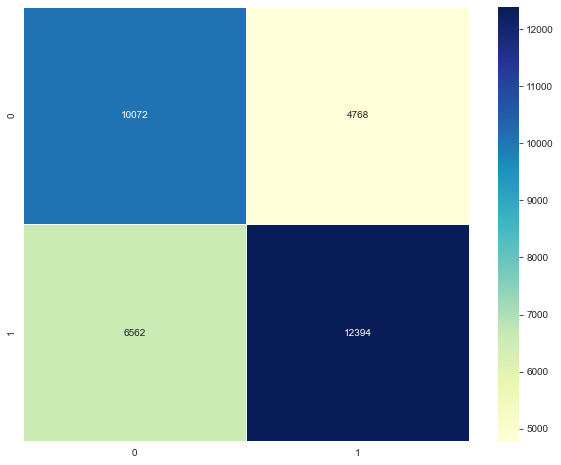

In [53]:
cfm = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [54]:
logistic_regression.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Standardization and model evaluation

In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
# define features to be scaled 
# col_scale = ['converted_pledged_amount', 'ratio_target', 'duration', 'convert_goal']
col_scale = ['duration', 'convert_goal']

scaler = StandardScaler()

X_train_stand = scaler.fit_transform(X_train[col_scale])
X_test_stand = scaler.transform(X_test[col_scale])

In [57]:
X_train_preprocessed = np.concatenate([X_train_stand, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_stand, X_test.drop(col_scale, axis=1)], axis=1)

In [58]:
from sklearn.metrics import classification_report

logistic_regression2 = LogisticRegression(max_iter=1000)
logistic_regression2.fit(X_train_preprocessed, y_train)
y_pred = logistic_regression2.predict(X_test_preprocessed)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))


print("Logistic regression score for training set:", round(logistic_regression2.score(X_train_preprocessed, y_train),5))
print("Logistic regression score for test set:", round(logistic_regression2.score(X_test_preprocessed, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print(logistic_regression2.coef_)

/Users/julianeberek/neuefische/kickstar/.venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Accuracy:  0.7253225233755474
Logistic regression score for training set: 0.72521
Logistic regression score for test set: 0.72532

Classification report:
              precision    recall  f1-score   support

      failed       0.70      0.67      0.68     14840
  successful       0.75      0.77      0.76     18956

    accuracy                           0.73     33796
   macro avg       0.72      0.72      0.72     33796
weighted avg       0.72      

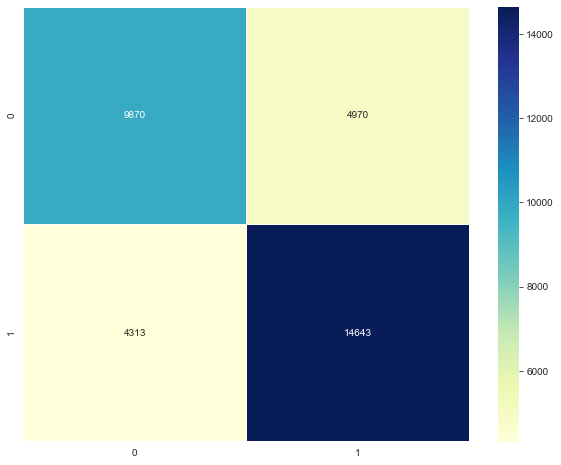

In [59]:
cfm = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [60]:
# Defining hyperparameters with GridSearch

In [61]:
# Define parameter grid for randomized search
from timeit import default_timer as timer

param_grid = {"penalty" : ["l1", "l2", "elasticnet", "none"],
              "solver" : ["lbfgs", "newton-cg", "saga"],
              "max_iter" : [500, 1000, 1500]
             }

# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(LogisticRegression(random_state=RSEED), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10)

# Fit randomized search object to data
start = timer()
rs.fit(X_train_preprocessed, y_train)
end = timer()
rgs_time = end-start

Fitting 5 folds for each of 10 candidates, totalling 50 fits
/Users/julianeberek/neuefische/kickstar/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.72465469        nan 0.7248914  0.72471386 0.72517989
 0.72471386 0.72451413        nan 0.72519469]
  warnings.warn(
/Users/julianeberek/neuefische/kickstar/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [63]:
# Best score
print('Best score:', round(rs.best_score_, 3))

# Best parameters
print('Best parameters:', rs.best_params_)

Best score: 0.725
Best parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1500}


In [64]:
def print_pretty_summary(name, model, y_test, y_pred_test):
    print(name)
    print('=======================')
    #print('loss: {}'.format(model.loss))
    #print('alpha: {}'.format(model.alpha))
    print('penalty: {}'.format(model.penalty))
    accuracy = accuracy_score(y_test, y_pred_test)
    print('Test accuracy: {:2f}'.format(accuracy))
    return accuracy

In [65]:
# Assigning the fitted SGDClassifier model with best parameter combination to a new variable sgd_best
log_reg_best_rs = rs.best_estimator_

# Making predictions on the test set
y_pred_test_rs = log_reg_best_rs.predict(X_test_preprocessed)

# Let us print out the performance of our model on the test set.
rsgd_accuracy = print_pretty_summary('Log Reg model (randomizedGSCV)', log_reg_best_rs, y_test, y_pred_test_rs)

Log Reg model (randomizedGSCV)
penalty: l2
Test accuracy: 0.725470


In [66]:
# Applying best parameters to model 

logistic_regression2 = LogisticRegression(solver='newton-cg', penalty='none', max_iter=1500)
logistic_regression2.fit(X_train_preprocessed, y_train)
y_pred = logistic_regression2.predict(X_test_preprocessed)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))


print("Logistic regression score for training set:", round(logistic_regression2.score(X_train_preprocessed, y_train),5))
print("Logistic regression score for test set:", round(logistic_regression2.score(X_test_preprocessed, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print(logistic_regression2.coef_)

Accuracy:  0.7252041661735117
Logistic regression score for training set: 0.72481
Logistic regression score for test set: 0.7252

Classification report:
              precision    recall  f1-score   support

      failed       0.69      0.67      0.68     14840
  successful       0.75      0.77      0.76     18956

    accuracy                           0.73     33796
   macro avg       0.72      0.72      0.72     33796
weighted avg       0.72      0.73      0.72     33796

[[-2.14035473e-01 -6.13043282e+00  2.55850983e+00 -5.50332145e-03
   1.96739776e-02 -1.46753379e-03 -2.38987718e-02 -2.71132876e-01
   3.21196035e-01 -7.85707641e-02  3.57485080e-01  3.05467652e-01
   1.84604598e-02  3.70836382e-01 -1.08681808e-02  4.01481704e-01
   5.92956505e-01  1.55809210e+00  1.43811414e-01 -3.18535339e-01
   5.34715777e-01  1.13966542e+00 -3.98024932e-01  1.23378391e-02
   1.62738520e-01  3.41781643e-01  3.79146934e-01  7.84856640e-01
   5.73735189e-01]]


Feature: 0, Score: -0.25895
Feature: 1, Score: -18.30580
Feature: 2, Score: 2.45043
Feature: 3, Score: -0.00555
Feature: 4, Score: 0.01757
Feature: 5, Score: -0.00309
Feature: 6, Score: -0.02032
Feature: 7, Score: 0.39273
Feature: 8, Score: -0.02012
Feature: 9, Score: 0.43996
Feature: 10, Score: 0.26831
Feature: 11, Score: 0.04316
Feature: 12, Score: 0.45794
Feature: 13, Score: 0.03493
Feature: 14, Score: 0.43111
Feature: 15, Score: 0.68639
Feature: 16, Score: 1.55803
Feature: 17, Score: 0.18399
Feature: 18, Score: -0.27095
Feature: 19, Score: 0.61572
Feature: 20, Score: 1.14205
Feature: 21, Score: -0.25550
Feature: 22, Score: 0.06277
Feature: 23, Score: 0.22007
Feature: 24, Score: 0.39850
Feature: 25, Score: 0.44610
Feature: 26, Score: 0.83998
Feature: 27, Score: 0.60265


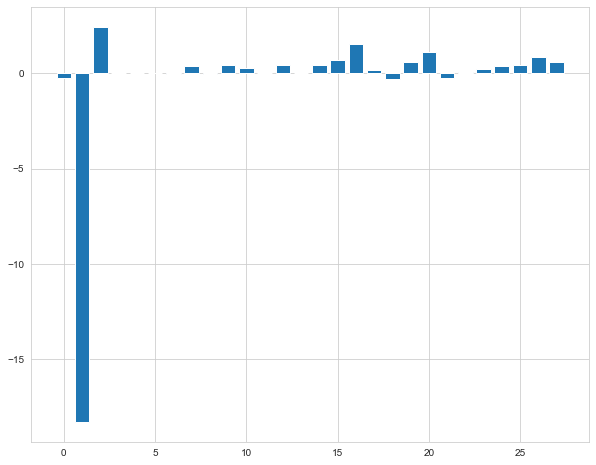

In [32]:
#Calculate feature importance for best regression model

from matplotlib import pyplot

importance = logistic_regression2.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [57]:
features_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168979 entries, 0 to 168978
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   staff_pick     168979 non-null  bool   
 1   subcategy_id   168979 non-null  int64  
 2   category_id    168979 non-null  int64  
 3   month_project  168979 non-null  int64  
 4   weekday        168979 non-null  int64  
 5   duration       168979 non-null  int64  
 6   convert_goal   168979 non-null  float64
 7   country_AU     168979 non-null  uint8  
 8   country_BE     168979 non-null  uint8  
 9   country_CA     168979 non-null  uint8  
 10  country_CH     168979 non-null  uint8  
 11  country_DE     168979 non-null  uint8  
 12  country_DK     168979 non-null  uint8  
 13  country_ES     168979 non-null  uint8  
 14  country_FR     168979 non-null  uint8  
 15  country_GB     168979 non-null  uint8  
 16  country_HK     168979 non-null  uint8  
 17  country_IE     168979 non-nul

In [34]:
features_raw.describe()

,subcategy_id,category_id,month_project,weekday,duration,convert_goal,country_AU,country_BE,country_CA,country_CH,country_DE,country_DK,country_ES,country_FR,country_GB,country_HK,country_IE,country_IT,country_JP,country_LU,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
count,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,1.689790e+05,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000,168979.000000
mean,171.895200,11.776842,6.426307,2.379793,32.450583,4.109688e+04,0.022701,0.002551,0.045242,0.003024,0.015375,0.004208,0.008569,0.011848,0.105788,0.003888,0.002923,0.010694,0.001337,0.000254,0.009895,0.008587,0.002349,0.004438,0.006350,0.002775,0.724995
std,134.314192,5.620951,3.350045,1.795448,11.748270,1.110957e+06,0.148949,0.050439,0.207836,0.054908,0.123038,0.064730,0.092172,0.108200,0.307567,0.062233,0.053990,0.102856,0.036547,0.015950,0.098979,0.092267,0.048414,0.066474,0.079433,0.052610,0.446518
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,10.000000,4.000000,1.000000,29.000000,1.500000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,250.000000,12.000000,6.000000,2.000000,30.000000,5.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,301.000000,16.000000,9.000000,4.000000,34.000000,1.329770e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,389.000000,26.000000,12.000000,6.000000,93.000000,1.523501e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


AUC: 0.79245


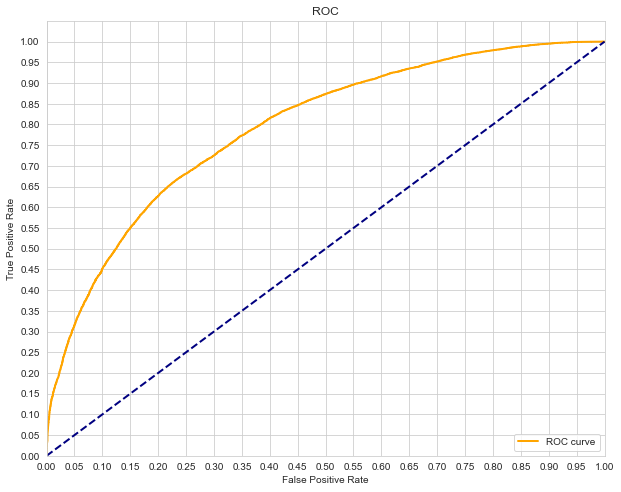

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = logistic_regression2.fit(X_train_preprocessed, y_train).decision_function(X_test_preprocessed)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

print('AUC:', round(auc(fpr, tpr),5))

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='orange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

#### Cross validation + SGD Classifier

In [36]:
log_reg_scaled = SGDClassifier(random_state=RSEED)
scores_scaled = cross_val_score(log_reg_scaled, X_train_preprocessed, y_train, cv=5, n_jobs=-1)

# Evaluation
print('Score (scaled):', round(scores_scaled.mean(), 4))

Score (scaled): 0.632


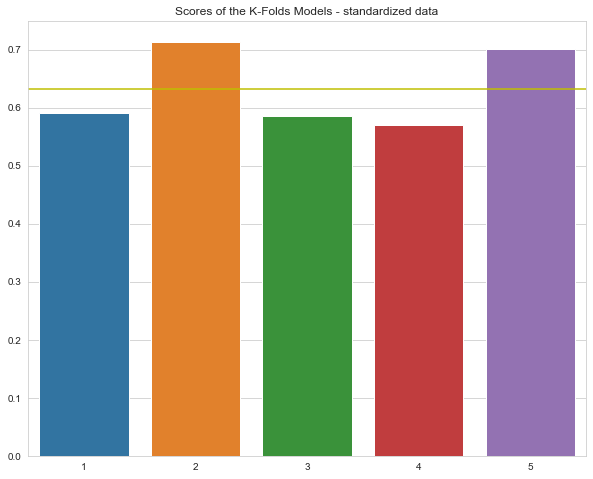

In [37]:
plt.axhline(y=scores_scaled.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores_scaled).set_title('Scores of the K-Folds Models - standardized data');

#### Ridge Regression

In [38]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

ridge = linear_model.Ridge(alpha=1)
ridge.fit(X_train_preprocessed, y_train)

# predict on test-set
y_pred_ridge = ridge.predict(X_test_preprocessed)

# R-squared scores for train and test set
train_score_ridge = ridge.score(X_train_preprocessed, y_train)
test_score_ridge = ridge.score(X_test_preprocessed, y_test)
print("Train score: {:.2f}".format(train_score_ridge))
print("Test score: {:.2f}".format(test_score_ridge))

# RMSE of test set
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_ridge)), 3))

Train score: 0.20
Test score: 0.21
RMSE: 0.442


In [39]:
#Ridge with alpha = 10 

ridge10 = linear_model.Ridge(alpha=10)
ridge10.fit(X_train_preprocessed, y_train)

# predict on test-set
y_pred_ridge10 = ridge10.predict(X_test_preprocessed)

# R-squared scores for train and test set
train_score_ridge = ridge10.score(X_train_preprocessed, y_train)
test_score_ridge = ridge10.score(X_test_preprocessed, y_test)
print("Train score: {:.2f}".format(train_score_ridge))
print("Test score: {:.2f}".format(test_score_ridge))

# RMSE of test set
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_ridge)), 3))

Train score: 0.20
Test score: 0.21
RMSE: 0.442


In [40]:
#Ridge with alpha = 0.1

ridge01 = linear_model.Ridge(alpha=0.1)
ridge01.fit(X_train_preprocessed, y_train)

# predict on test-set
y_pred_ridge01 = ridge01.predict(X_test_preprocessed)

# R-squared scores for train and test set
train_score_ridge = ridge01.score(X_train_preprocessed, y_train)
test_score_ridge = ridge01.score(X_test_preprocessed, y_test)
print("Train score: {:.2f}".format(train_score_ridge))
print("Test score: {:.2f}".format(test_score_ridge))

# RMSE of test set
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_ridge)), 3))

Train score: 0.20
Test score: 0.21
RMSE: 0.442


In [41]:
from sklearn.feature_selection import f_regression

coef = f_regression(X_test_preprocessed, y_test, center=True)
coef

(array([9.16441096e+02, 3.28330570e+01, 2.46324955e+03, 4.76730711e+03,
        1.06914773e+02, 7.13567462e+00, 2.48539738e+01, 4.07316774e+01,
        1.05528602e+01, 8.19333939e-01, 1.44594757e+01, 3.95367260e+01,
        1.61169649e-01, 1.89794515e+01, 5.92462578e+00, 2.08697454e+01,
        7.54341743e+00, 9.61042525e-02, 1.29212441e+02, 1.23996526e-02,
        1.26172947e+00, 2.56592141e+01, 6.13421368e+01, 1.69597297e+00,
        1.05013778e+00, 8.39010870e+00, 3.91583217e-01, 9.39785033e+01]),
 array([1.18598019e-198, 1.01274617e-008, 0.00000000e+000, 0.00000000e+000,
        5.06445295e-025, 7.56014081e-003, 6.21470354e-007, 1.76893425e-010,
        1.16121675e-003, 3.65381431e-001, 1.43459187e-004, 3.25877446e-010,
        6.88084463e-001, 1.32522776e-005, 1.49358527e-002, 4.93333779e-006,
        6.02615755e-003, 7.56557652e-001, 6.90548627e-030, 9.11336513e-001,
        2.61331958e-001, 4.09486791e-007, 4.93671858e-015, 1.92824343e-001,
        3.05482691e-001, 3.77510325e-0

#### Naive Bayes

In [42]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train_preprocessed, y_train);



In [43]:
y_prob = model.predict_proba(X_test)

print(model.score)
y_prob[:10].round(2)

<bound method ClassifierMixin.score of GaussianNB()>


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

#### KNN

In [44]:
from sklearn.neighbors import KNeighborsClassifier

In [45]:
# KNN with 5 neighbours

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_preprocessed, np.ravel(y_train))

KNeighborsClassifier(metric='euclidean')

Accuracy: 0.74
--------------------------------------------------


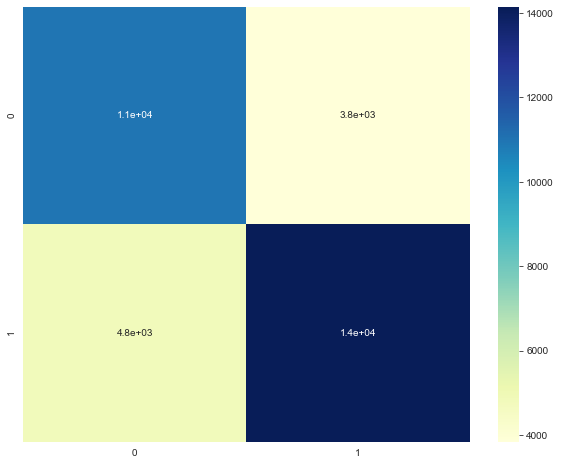

In [46]:
# Predict on test set
y_pred = knn.predict(X_test_preprocessed)

# Print accuracy score 
print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
print("-----"*10)

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGnBu');

In [47]:
# 4 neighbours
knn2 = KNeighborsClassifier(n_neighbors=4, metric='euclidean')
knn2.fit(X_train_preprocessed, np.ravel(y_train))

KNeighborsClassifier(metric='euclidean', n_neighbors=4)

Accuracy: 0.74
--------------------------------------------------


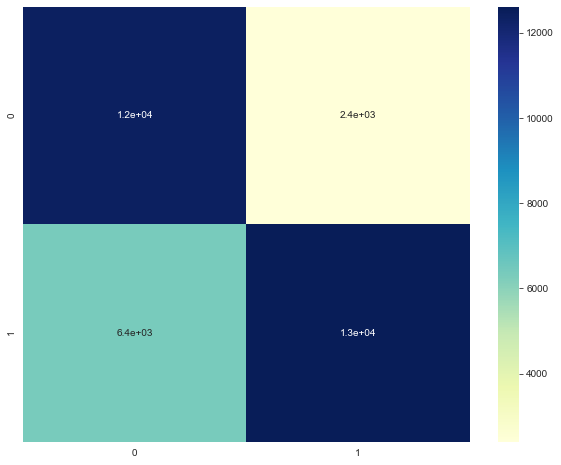

In [48]:
# Predict on test set
y_pred = knn2.predict(X_test_preprocessed)

# Print accuracy score 
print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
print("-----"*10)

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGnBu');

In [59]:
# 8 neighbours
knn8 = KNeighborsClassifier(n_neighbors=8, metric='euclidean')
knn8.fit(X_train_preprocessed, np.ravel(y_train))

KNeighborsClassifier(metric='euclidean', n_neighbors=8)

In [60]:
# Predict on test set
y_pred = knn8.predict(X_test_preprocessed)

# Print accuracy score 
print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
print("-----"*10)

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGnBu', fmt='g');

Accuracy: 0.75
--------------------------------------------------


AttributeError: 'QuadMesh' object has no property 'format'

Text(0, 0.5, 'Model Accuracy')

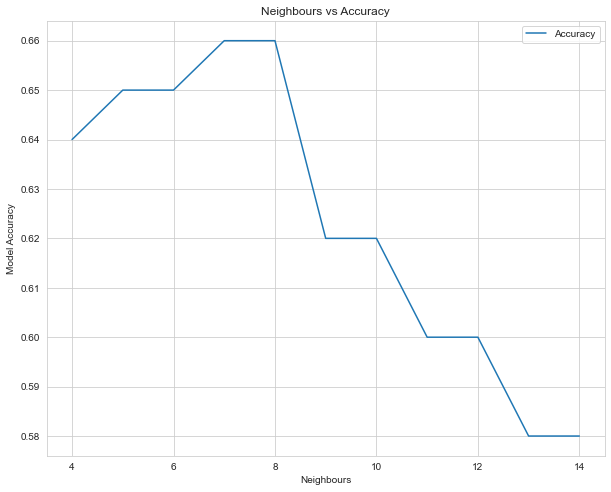

In [51]:
# Calculating accuracy for a range of k-neighbours 
nn = []
accuracy = []
for i in range(4,15):
    nn.append(i)
    knn_x = KNeighborsClassifier(n_neighbors= i, metric='euclidean')
    knn_x.fit(X_train_preprocessed, np.ravel(y_train))
    # Predict on test set
    y_pred = knn_x.predict(X_test_preprocessed)

    # Get accuracy score
    accuracy.append(accuracy_score(y_test, y_pred).round(2))

df = pd.DataFrame({'Neighbours':nn, 'Accuracy' : accuracy})
df.plot(x='Neighbours',y='Accuracy')
plt.title('Neighbours vs Accuracy')
plt.xlabel('Neighbours')
plt.ylabel('Model Accuracy')

In [ ]:
# Why is the highest accuracy only 0.66? knn8 model shows 0.75 accuracy ... 

AUC: 0.81904


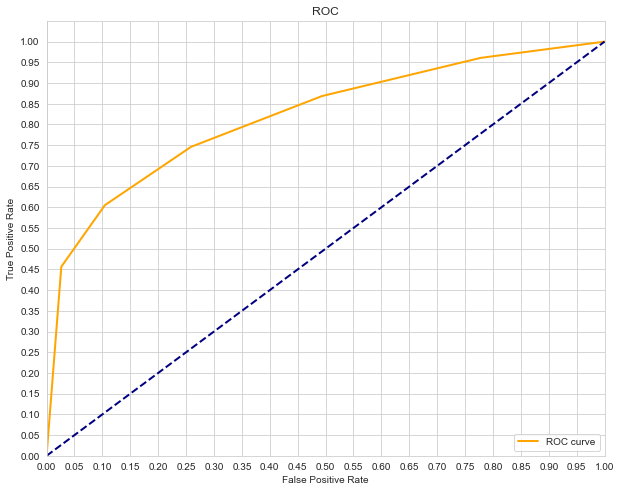

In [127]:
# ROC curve for best KNN model 

y_scores = knn.predict_proba(X_test_preprocessed)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

print('AUC:', round(auc(fpr, tpr),5))

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='orange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [1]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(knn8, random_state=1).fit(X_test_preprocessed, y_test)
eli5.show_weights(perm, feature_names = X_test_preprocessed.columns.tolist())


NameError: name 'knn8' is not defined

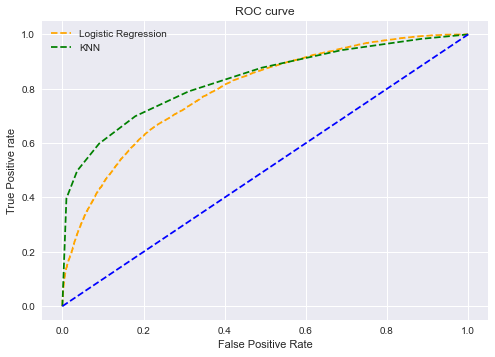

In [54]:
# Plotting ROC curves of models into 1 
plt.style.use('seaborn')

pred_prob1 = logistic_regression2.predict_proba(X_test_preprocessed)
pred_prob2 = knn8.predict_proba(X_test_preprocessed)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();